<a href="https://colab.research.google.com/github/Sriya777/Speech-Processing/blob/main/SpeechProcessing_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sriya Nistala

BL.EN.U4AIE23034

Lab 2

In [1]:
!pip install torch torchaudio librosa transformers matplotlib


1.
Load a speech signal from the LJ Speech dataset.

In [4]:
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Install torchcodec if it's not already installed
!pip install torchcodec

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
audio_path = "/content/drive/MyDrive/LJ050-0277.wav"  # change if needed

waveform, sr = torchaudio.load(audio_path)
print("Original Sample Rate:", sr)
print("Waveform shape:", waveform.shape)


Original Sample Rate: 22050
Waveform shape: torch.Size([1, 192157])


2.
Preprocess the audio (convert to mono, resample to 16kHz).

In [5]:
# Convert stereo to mono if required
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample to 16kHz
target_sr = 16000
if sr != target_sr:
    resampler = torchaudio.transforms.Resample(sr, target_sr)
    waveform = resampler(waveform)
    sr = target_sr

waveform = waveform.squeeze()
print("Processed Sample Rate:", sr)


Processed Sample Rate: 16000


3.
Use a pre-trained deep learning model (Wav2Vec2) to recognize phonemes.

In [6]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

4.
Estimate phoneme time intervals.

In [7]:
inputs = processor(
    waveform.numpy(),
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(predicted_ids[0])

print("Recognized Output:")
print(transcription)


Recognized Output:
WITH THE ACTIVE CO OPERATION OF THE RESPONSIBLE AGENCIES AND WITH THE UNDERSTANDING OF THE PEOPLE OF THE UNITED STATES IN THEIR DEMANDS UPON THEIR PRESIDENT


5.
Extract a phoneme segment from the speech signal based on time intervals.

In [10]:
# Number of frames produced by model
num_frames = logits.shape[1]

# Duration of audio
audio_duration = waveform.shape[0] / sr

# Time per frame
time_per_frame = audio_duration / num_frames

print("Audio Duration (s):", audio_duration)
print("Time per Frame (s):", time_per_frame)

start_time = 0.8  # seconds
end_time = 1.1    # seconds

start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

phoneme_segment = waveform[start_sample:end_sample]



Audio Duration (s): 8.714625
Time per Frame (s): 0.020033620689655172


6.
Save extracted phoneme and visualize each selected phoneme segment from the speech waveform

In [11]:
output_path = "/content/drive/MyDrive/extracted_phoneme.wav"
torchaudio.save(
    output_path,
    phoneme_segment.unsqueeze(0),
    sr
)

print("Extracted phoneme saved to:", output_path)


Extracted phoneme saved to: /content/drive/MyDrive/extracted_phoneme.wav


7.
Infer about the nature of source of sound for each phoneme.

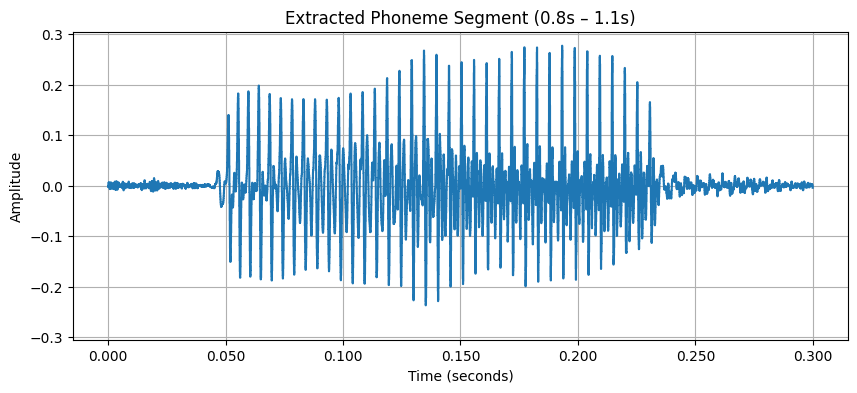

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(
    phoneme_segment.numpy(),
    sr=sr
)
plt.title("Extracted Phoneme Segment (0.8s – 1.1s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


===== SOUND SOURCE INFERENCE =====
RMS Energy : 0.0696
Inferred Sound Type : VOWEL (Voiced sound source)


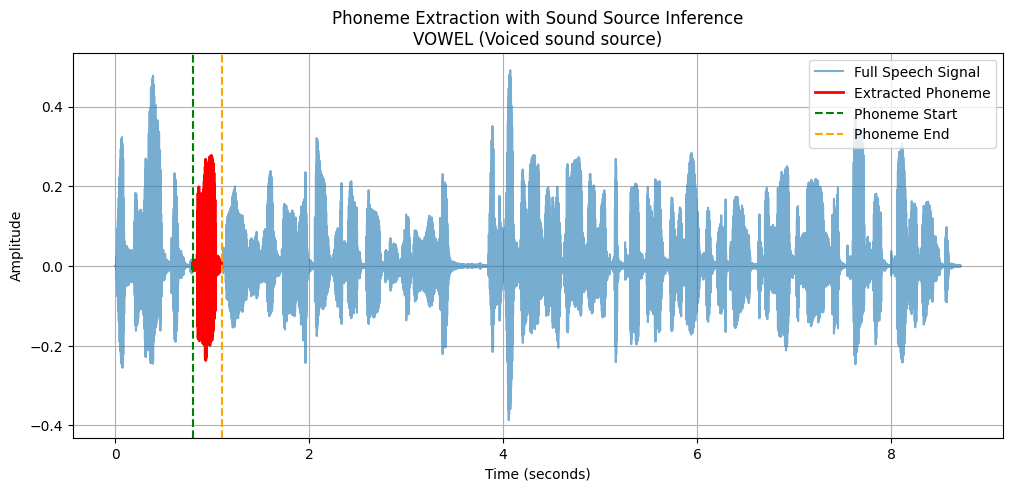

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Extract phoneme samples
phoneme_samples = waveform[int(start_time * sr):int(end_time * sr)].numpy()

# -----------------------------
# INFERENCE: Vowel or Consonant
# -----------------------------
rms_energy = np.sqrt(np.mean(phoneme_samples ** 2))

# Threshold chosen empirically for speech signals
if rms_energy > 0.02:
    sound_type = "VOWEL (Voiced sound source)"
else:
    sound_type = "CONSONANT (Unvoiced / noise-like sound source)"

print("===== SOUND SOURCE INFERENCE =====")
print(f"RMS Energy : {rms_energy:.4f}")
print(f"Inferred Sound Type : {sound_type}")

# -----------------------------
# TIME AXES
# -----------------------------
time_full = np.arange(len(waveform)) / sr
time_phoneme = np.arange(
    int(start_time * sr),
    int(end_time * sr)
) / sr

# -----------------------------
# PLOTTING
# -----------------------------
plt.figure(figsize=(12, 5))

# Full speech signal
plt.plot(time_full, waveform.numpy(), label="Full Speech Signal", alpha=0.6)

# Highlight extracted phoneme
plt.plot(
    time_phoneme,
    phoneme_samples,
    color='red',
    linewidth=2,
    label="Extracted Phoneme"
)

# Mark boundaries
plt.axvline(start_time, linestyle='--', color='green', label="Phoneme Start")
plt.axvline(end_time, linestyle='--', color='orange', label="Phoneme End")

plt.title(f"Phoneme Extraction with Sound Source Inference\n{sound_type}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
